## Logistic Regression Experiments

## Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import joblib
import gensim.downloader as api

In [2]:
random.seed(42)
np.random.seed(42)

- Load the train and test files 

In [3]:
train_df = pd.read_csv("train_data.csv")
val_df  = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")

In [4]:
print(f"Train: {len(train_df):>6} rows")
print(f" Val : {len(val_df):>6} rows")
print(f" Test: {len(test_df):>6} rows")

Train:   8000 rows
 Val :   1000 rows
 Test:   1000 rows


## Word2Vec - Experiment 2 (Google Word2Vec)

In [5]:
# Load the Google's pre-trained Word2Vec
wv = api.load("word2vec-google-news-300") 

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [6]:
# helper to compute mean embedding for a document
def doc_vector(doc, wv_model):
    tokens = [tok for tok in doc.split() if tok in wv_model]
    if not tokens:
        return np.zeros(wv_model.vector_size)
    return np.mean([wv_model[t] for t in tokens], axis=0)

In [7]:
# Build feature matrices from raw text
X_train = np.vstack(train_df["text"].astype(str).apply(lambda d: doc_vector(d, wv)))
X_val   = np.vstack(val_df  ["text"].astype(str).apply(lambda d: doc_vector(d, wv)))
X_test  = np.vstack(test_df ["text"].astype(str).apply(lambda d: doc_vector(d, wv)))

y_train = train_df["sentiment_id"]
y_val   = val_df  ["sentiment_id"]
y_test  = test_df ["sentiment_id"]

- Hyperparameter tuning 

In [8]:
def objective(trial):
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)

    combo = trial.suggest_categorical(
        "penalty_solver",
        ["l1_saga", "l2_lbfgs", "l2_sag", "l2_saga"]
    )
    penalty, solver = combo.split("_")

    clf = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight="balanced",
        max_iter=10000,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    preds = clf.predict(X_val)
    return f1_score(y_val, preds, average="macro")

In [9]:
sampler = TPESampler(seed=42)
study   = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

print("Best macro-F1:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-06-21 23:34:47,883] A new study created in memory with name: no-name-1d410d76-b343-4ed6-956b-06ec2e0ca3c0
[I 2025-06-21 23:34:49,107] Trial 0 finished with value: 0.6009162497024252 and parameters: {'C': 0.17670169402947947, 'penalty_solver': 'l1_saga'}. Best is trial 0 with value: 0.6009162497024252.
[I 2025-06-21 23:34:49,316] Trial 1 finished with value: 0.5587386059714858 and parameters: {'C': 0.00862913219007186, 'penalty_solver': 'l2_lbfgs'}. Best is trial 0 with value: 0.6009162497024252.
[I 2025-06-21 23:34:49,383] Trial 2 finished with value: 0.061156524371783226 and parameters: {'C': 0.0013289448722869186, 'penalty_solver': 'l1_saga'}. Best is trial 0 with value: 0.6009162497024252.
[I 2025-06-21 23:34:49,489] Trial 3 finished with value: 0.5615279979088535 and parameters: {'C': 0.012601639723276799, 'penalty_solver': 'l2_lbfgs'}. Best is trial 0 with value: 0.6009162497024252.
[I 2025-06-21 23:34:50,395] Trial 4 finished with value: 0.6549380451618163 and parameters:

Best macro-F1: 0.6582213210420489
Best params:
  C: 36.576102716321046
  penalty_solver: l2_saga


In [11]:
best = study.best_params

pipeline = Pipeline([
  ("clf", LogisticRegression(
      C            = best["C"],
      penalty      = best["penalty_solver"].split("_")[0],
      solver       = best["penalty_solver"].split("_")[1],
      class_weight = "balanced",
      random_state = 42,
      max_iter     = 5000
  ))
])

In [12]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 LogisticRegression(C=36.576102716321046,
                                    class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='saga'))])

In [14]:
y_pred = pipeline.predict(X_test)
print(classification_report(test_df["sentiment_id"],y_pred,target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.65      0.76      0.70       160
     Neutral       0.32      0.65      0.43       101
    Positive       0.98      0.80      0.88       739

    accuracy                           0.78      1000
   macro avg       0.65      0.74      0.67      1000
weighted avg       0.86      0.78      0.81      1000



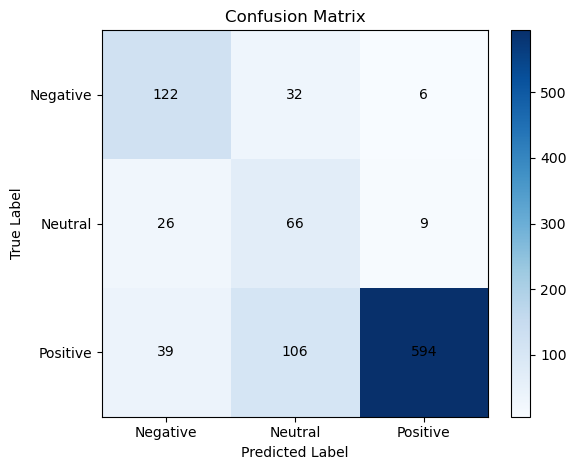

In [15]:
# Plot the confusion matrix 
cm = confusion_matrix(test_df["sentiment_id"], y_pred)
labels = ["Negative", "Neutral", "Positive"]

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")        
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [16]:
joblib.dump(pipeline, "lr_word2vec_experiment2.pkl")

['lr_word2vec_experiment2.pkl']

In [18]:
def oov_rate(texts, wv_model):
    total, oov = 0, 0
    for doc in texts:
        for tok in str(doc).split():
            total += 1
            if tok not in wv_model:
                oov += 1
    return oov/total

print("GoogleNews OOV:",  oov_rate(train_df["text"], wv))

GoogleNews OOV: 0.2146318824701953
